<a href="https://colab.research.google.com/github/Alisoltan82/LiverDisease_Detection_YOLOv8/blob/main/liverdisease.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob as glob
import cv2
import os
import random

In [2]:
!nvidia-smi

Fri Dec 22 06:13:27 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="W4eUr4qeRPhzBaUNMuF4")
project = rf.workspace("roboflow-100").project("liver-disease")
dataset = project.version(2).download("yolov8")


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.0/69.0 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.3/158.3 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 17.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.5/77.5 kB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 7.4 MB/s eta 0:00:00
  Attempting uninstall: pyparsing
    Found existing installation: pyparsing 3.1.1
    Uninstalling pyparsing-3.1.1:
      Successfully uninstalled pyparsing-3.1.1
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.8.1.78
    Uninstalling opencv-python-headless-4.8.1.78:
      Successfully uninstal

loading Roboflow workspace...
loading Roboflow project...
[WARNING] we noticed you are downloading a `yolov8` datasets but you don't have `ultralytics` installed. Roboflow `.deploy` supports only models trained with `ultralytics==8.0.196`, to intall it `pip install ultralytics==8.0.196`.



Extracting Dataset Version Zip to liver-disease-2 in yolov8:: 100%|██████████| 7964/7964 [00:02<00:00, 3894.75it/s]


In [4]:
#number of images per each file [train , val , test]
!ls -1 '/content/liver-disease-2/train/images' | wc -l
!ls -1 '/content/liver-disease-2/valid/images' | wc -l
!ls -1 '/content/liver-disease-2/test/images' | wc -l

2782
794
400


In [5]:
!pip install ultralytics
from ultralytics import YOLO

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 661.2/661.2 kB 9.2 MB/s eta 0:00:00


In [6]:
# function to read bounding boxes on cv2 (from yolo format to x min , y min )
def yolo2box(bboxes):
  xmin , ymin = bboxes[0] - bboxes[2]/2 , bboxes[1] - bboxes[3]/2
  xmax , ymax = bboxes[0] + bboxes[2]/2 , bboxes[1] + bboxes[3]/2

  return xmin , ymin , xmax , ymax

In [7]:
#plotting bounding boxes to images

def plot_box(image , bboxes , labels):
  #image height & width
  h, w , c = image.shape

  for box_num, box in enumerate(bboxes):
      x1 , y1 , x2 , y2 = yolo2box(box)

      #denormalizing the coordinates to fit the w , h per each image
      xmin = int(x1*w)
      ymin = int(y1*h)
      xmax = int(x2*w)
      ymax = int(y2*h)

      cv2.rectangle(
          image,
          (xmin , ymin) , (xmax , ymax),
          color = (0,0,255),
          thickness = 2
      )


  return image

In [8]:
#function to plot bboxes to their respective image
def plot(image_path , label_path , num_samples):
  all_images = []
  all_images.extend(glob.glob(image_path + '/*.jpg'))

  all_images.sort()
  num_images = len(all_images)

  plt.figure(figsize = (8,8))
  for i in range(num_samples):
    r = random.randint(0 , num_images -1)
    image_name = all_images[r]
    image_name = '.'.join(image_name.split(os.path.sep)[-1].split('.')[:-1])

    image = cv2.imread(all_images[r])

    #labels
    with open(os.path.join(label_path , image_name + '.txt') , 'r') as f:
      bboxes = []
      labels = []
      label_lines = f.readlines()

      for label_line in label_lines:
        label = label_line[0]
        bbox_string = label_line[2:]

        x_c, y_c , w, h = bbox_string.split(' ') #separated by space and [c] for center

        x_c = float(x_c)
        y_c = float(y_c)
        w = float(w)
        h = float(h)

        bboxes.append([x_c , y_c , w , h])
        labels.append(label)

    result_image = plot_box(image , bboxes , labels)
    plt.subplot(3,3 , i+1)
    plt.imshow(result_image[:,:,::-1])
  plt.tight_layout()
  plt.show()


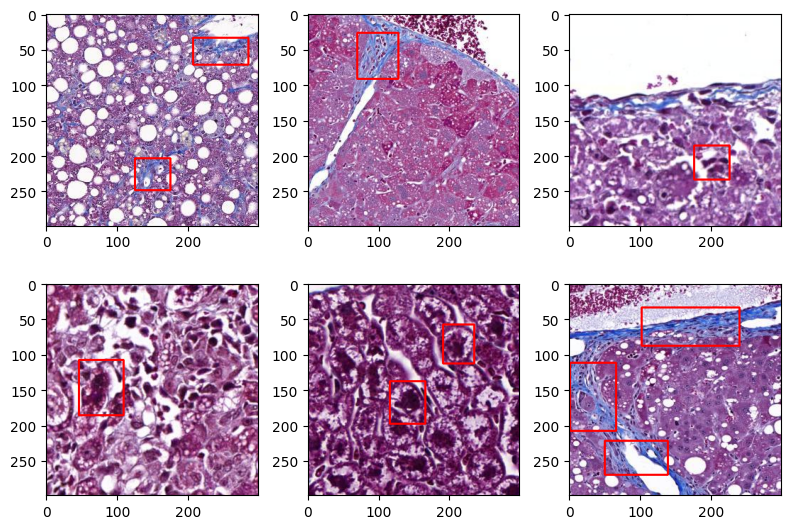

In [9]:
plot(
    image_path= '/content/liver-disease-2/train/images',
    label_path= '/content/liver-disease-2/train/labels',
    num_samples= 6
)

In [ ]:
model = YOLO("yolov8m.yaml") # new model from scratch

results = model.train(data = '/content/liver-disease-2/data.yaml' , epochs = 20)


                   from  n    params  module                                       arguments                     
  0                  -1  1      1392  ultralytics.nn.modules.conv.Conv             [3, 48, 3, 2]                 
  1                  -1  1     41664  ultralytics.nn.modules.conv.Conv             [48, 96, 3, 2]                
  2                  -1  2    111360  ultralytics.nn.modules.block.C2f             [96, 96, 2, True]             
  3                  -1  1    166272  ultralytics.nn.modules.conv.Conv             [96, 192, 3, 2]               
  4                  -1  4    813312  ultralytics.nn.modules.block.C2f             [192, 192, 4, True]           
  5                  -1  1    664320  ultralytics.nn.modules.conv.Conv             [192, 384, 3, 2]              
  6                  -1  4   3248640  ultralytics.nn.modules.block.C2f             [384, 384, 4, True]           
  7                  -1  1   1991808  ultralytics.nn.modules.conv.Conv             [384

train: Scanning /content/liver-disease-2/train/labels.cache... 2782 images, 8 backgrounds, 0 corrupt: 100%|██████████| 2782/2782 [00:00<?, ?it/s]

train: WARNING ⚠️ /content/liver-disease-2/train/images/208_5_14_31_jpg.rf.82f7adcfc8039be1329a0ad6dce37f71.jpg: 1 duplicate labels removed
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/liver-disease-2/valid/labels.cache... 794 images, 4 backgrounds, 0 corrupt: 100%|██████████| 794/794 [00:00<?, ?it/s]


Plotting labels to runs/detect/train4/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00125, momentum=0.9) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005), 83 bias(decay=0.0)
20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      8.68G      2.854      3.828      3.595         53        640: 100%|██████████| 174/174 [01:32<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:13<00:00,  1.91it/s]

                   all        794       1937       0.38      0.293      0.122     0.0612



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20       8.9G      2.146      2.865        2.7         64        640: 100%|██████████| 174/174 [01:30<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:12<00:00,  1.97it/s]

                   all        794       1937       0.16      0.399      0.154     0.0858



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      8.89G      1.881      2.518      2.423         75        640: 100%|██████████| 174/174 [01:28<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:12<00:00,  2.00it/s]

                   all        794       1937      0.174       0.43       0.16     0.0855



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      8.89G      1.772      2.383      2.291         53        640: 100%|██████████| 174/174 [01:28<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:12<00:00,  1.95it/s]

                   all        794       1937      0.275      0.259      0.182     0.0999



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      8.89G      1.674      2.216      2.199         47        640: 100%|██████████| 174/174 [01:29<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:12<00:00,  2.01it/s]

                   all        794       1937      0.704      0.335      0.304      0.188



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      8.91G      1.652      2.169      2.155         49        640: 100%|██████████| 174/174 [01:28<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:12<00:00,  2.01it/s]

                   all        794       1937      0.258      0.413       0.29       0.17



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      8.88G       1.59      2.087      2.101         72        640: 100%|██████████| 174/174 [01:29<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:12<00:00,  2.03it/s]

                   all        794       1937      0.248      0.471      0.291      0.172



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      8.93G      1.588      2.052      2.087         43        640: 100%|██████████| 174/174 [01:28<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:12<00:00,  2.03it/s]

                   all        794       1937      0.337      0.452      0.366      0.216



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      8.94G      1.548      2.019       2.06         54        640: 100%|██████████| 174/174 [01:28<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:12<00:00,  2.02it/s]

                   all        794       1937      0.628      0.295      0.358      0.225



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      8.93G      1.521      1.945      2.004         77        640: 100%|██████████| 174/174 [01:29<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:12<00:00,  2.04it/s]

                   all        794       1937       0.31      0.501      0.372      0.227


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20       8.9G      1.471      1.957        2.1         30        640: 100%|██████████| 174/174 [01:29<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:12<00:00,  2.03it/s]

                   all        794       1937      0.347      0.461      0.371      0.216



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      8.91G      1.465      1.903       2.09         30        640: 100%|██████████| 174/174 [01:27<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:12<00:00,  1.94it/s]

                   all        794       1937      0.376       0.55      0.433       0.26



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20       8.9G      1.434      1.827      2.059         40        640: 100%|██████████| 174/174 [01:27<00:00,  1.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:12<00:00,  2.05it/s]

                   all        794       1937       0.39      0.547      0.451      0.283



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20       8.9G      1.427      1.833      2.039         30        640: 100%|██████████| 174/174 [01:27<00:00,  1.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:12<00:00,  2.03it/s]

                   all        794       1937      0.383      0.513      0.417      0.261



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20       8.9G      1.386      1.749      2.009         31        640: 100%|██████████| 174/174 [01:28<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:12<00:00,  2.03it/s]

                   all        794       1937      0.423      0.479       0.43      0.271



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20       8.9G      1.373       1.76      1.979         37        640: 100%|██████████| 174/174 [01:27<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:12<00:00,  2.06it/s]

                   all        794       1937      0.428      0.534      0.473      0.298



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20       8.9G      1.365      1.726      1.982         24        640: 100%|██████████| 174/174 [01:27<00:00,  1.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:12<00:00,  2.02it/s]

                   all        794       1937      0.325      0.576      0.431      0.282



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      8.89G      1.341      1.686      1.958         31        640: 100%|██████████| 174/174 [01:27<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:12<00:00,  2.03it/s]

                   all        794       1937      0.443      0.542      0.497      0.311



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      8.89G      1.324      1.633      1.938         31        640: 100%|██████████| 174/174 [01:27<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:12<00:00,  2.06it/s]

                   all        794       1937      0.456      0.539      0.488      0.312



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      8.89G      1.332      1.623      1.943         28        640: 100%|██████████| 174/174 [01:27<00:00,  1.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:12<00:00,  2.03it/s]

                   all        794       1937      0.457      0.567      0.524      0.335



20 epochs completed in 0.606 hours.
Optimizer stripped from runs/detect/train4/weights/last.pt, 52.0MB
Optimizer stripped from runs/detect/train4/weights/best.pt, 52.0MB

Validating runs/detect/train4/weights/best.pt...
Ultralytics YOLOv8.0.228 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8m summary (fused): 218 layers, 25842076 parameters, 0 gradients, 78.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:18<00:00,  1.38it/s]


                   all        794       1937      0.454      0.568      0.524      0.335
            ballooning        794        417      0.517      0.847      0.782      0.584
              fibrosis        794        359      0.449      0.315      0.351      0.116
          inflammation        794        558      0.399      0.323      0.318      0.151
             steatosis        794        603      0.452      0.789      0.647      0.488
Speed: 0.2ms preprocess, 10.5ms inference, 0.0ms loss, 3.1ms postprocess per image
Results saved to runs/detect/train4


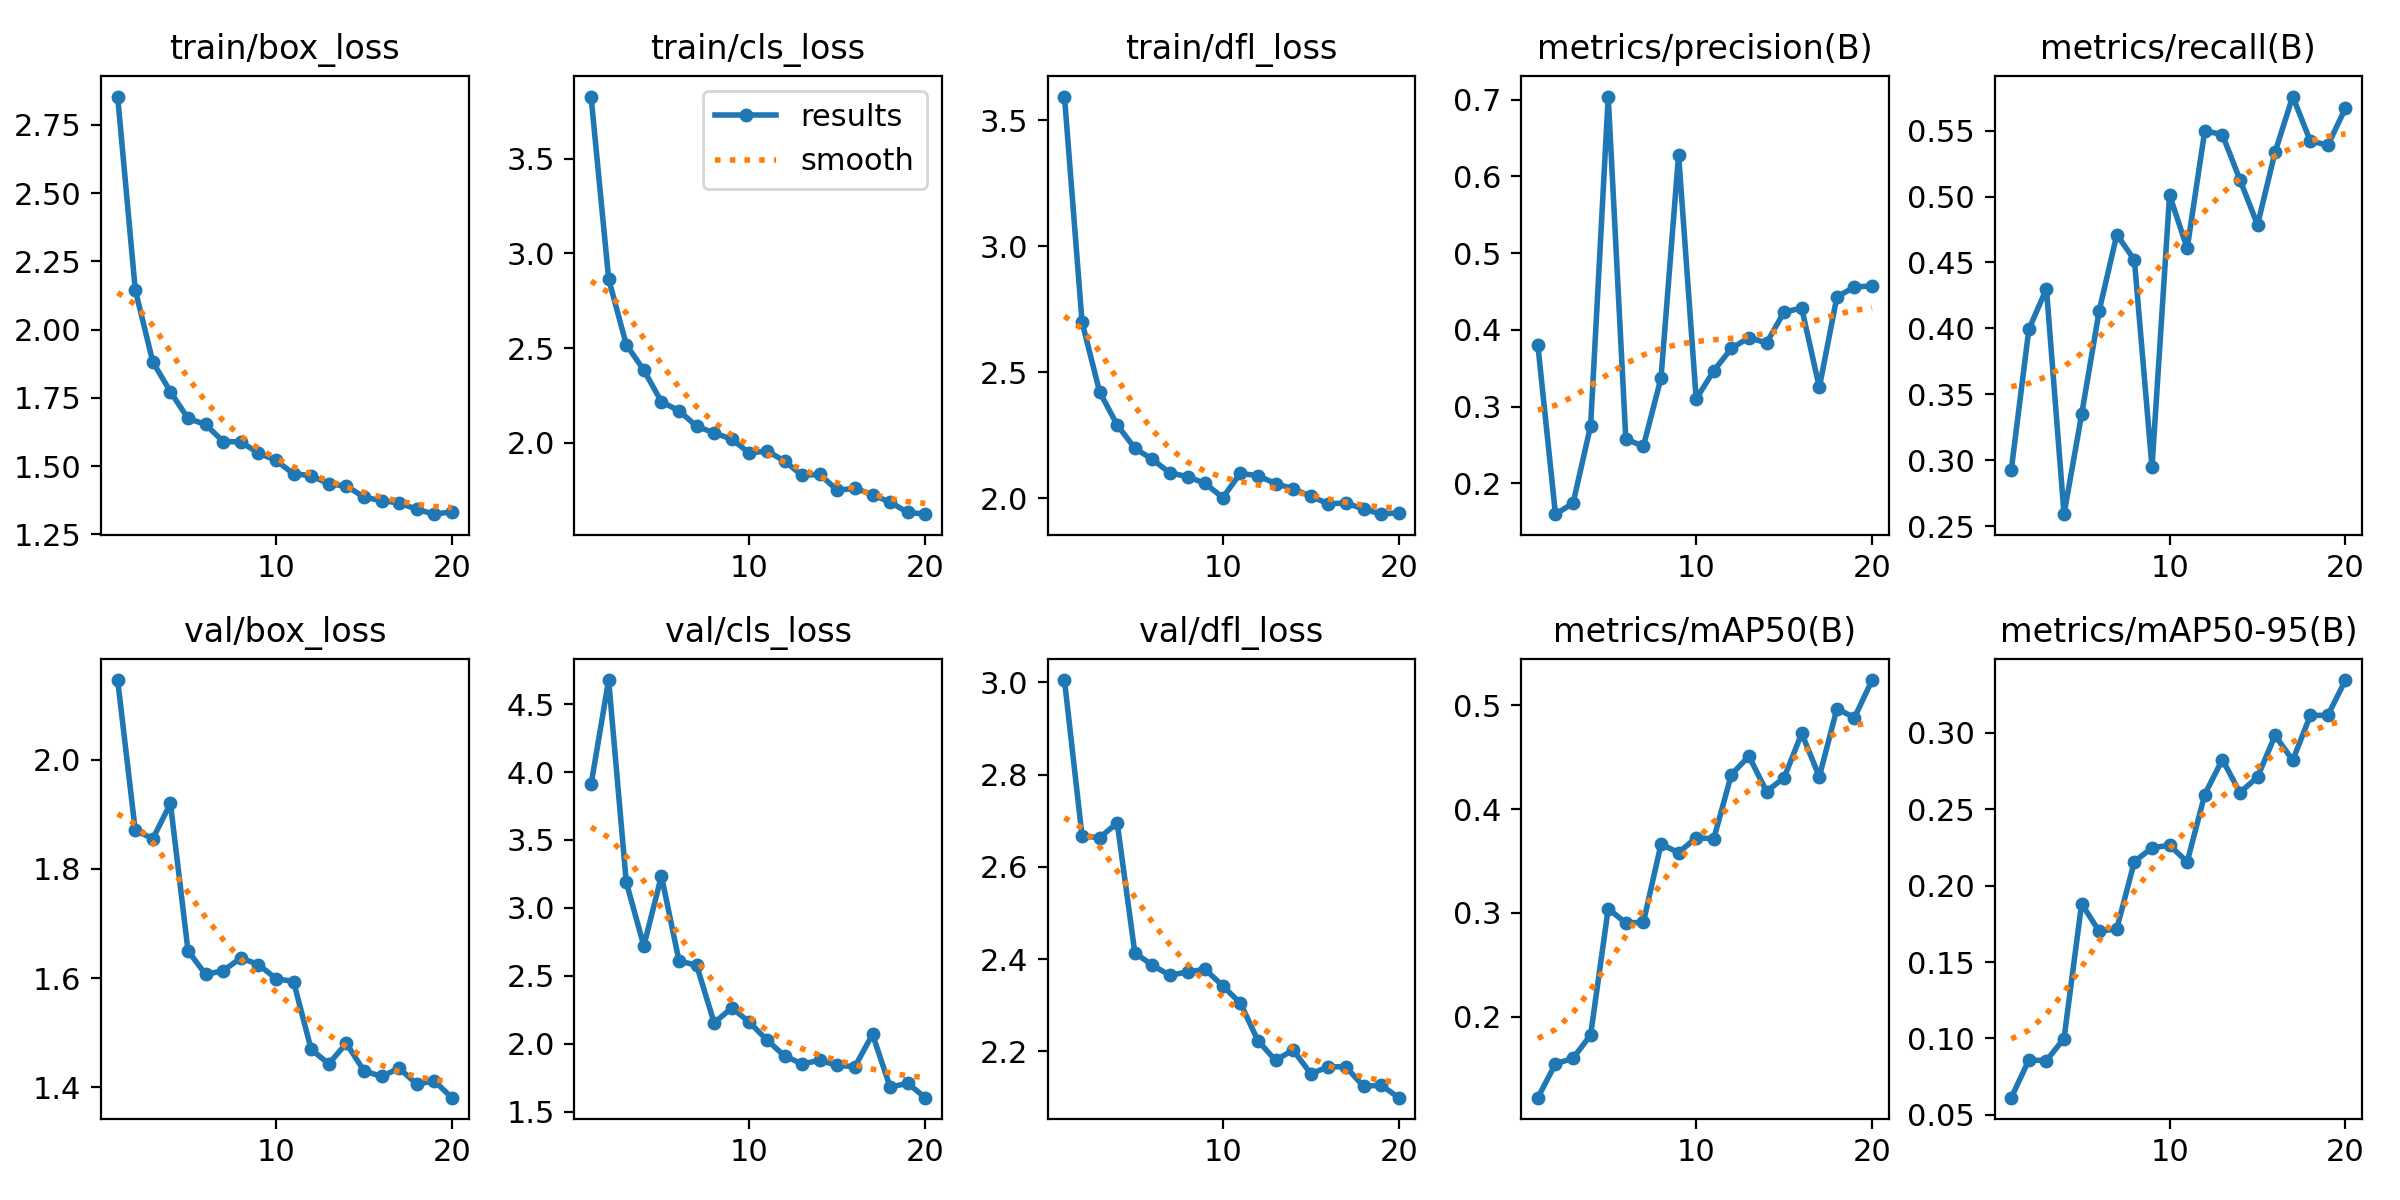

In [ ]:
from IPython.display import Image

Image('/content/runs/detect/train4/results.png') #display a raw model results

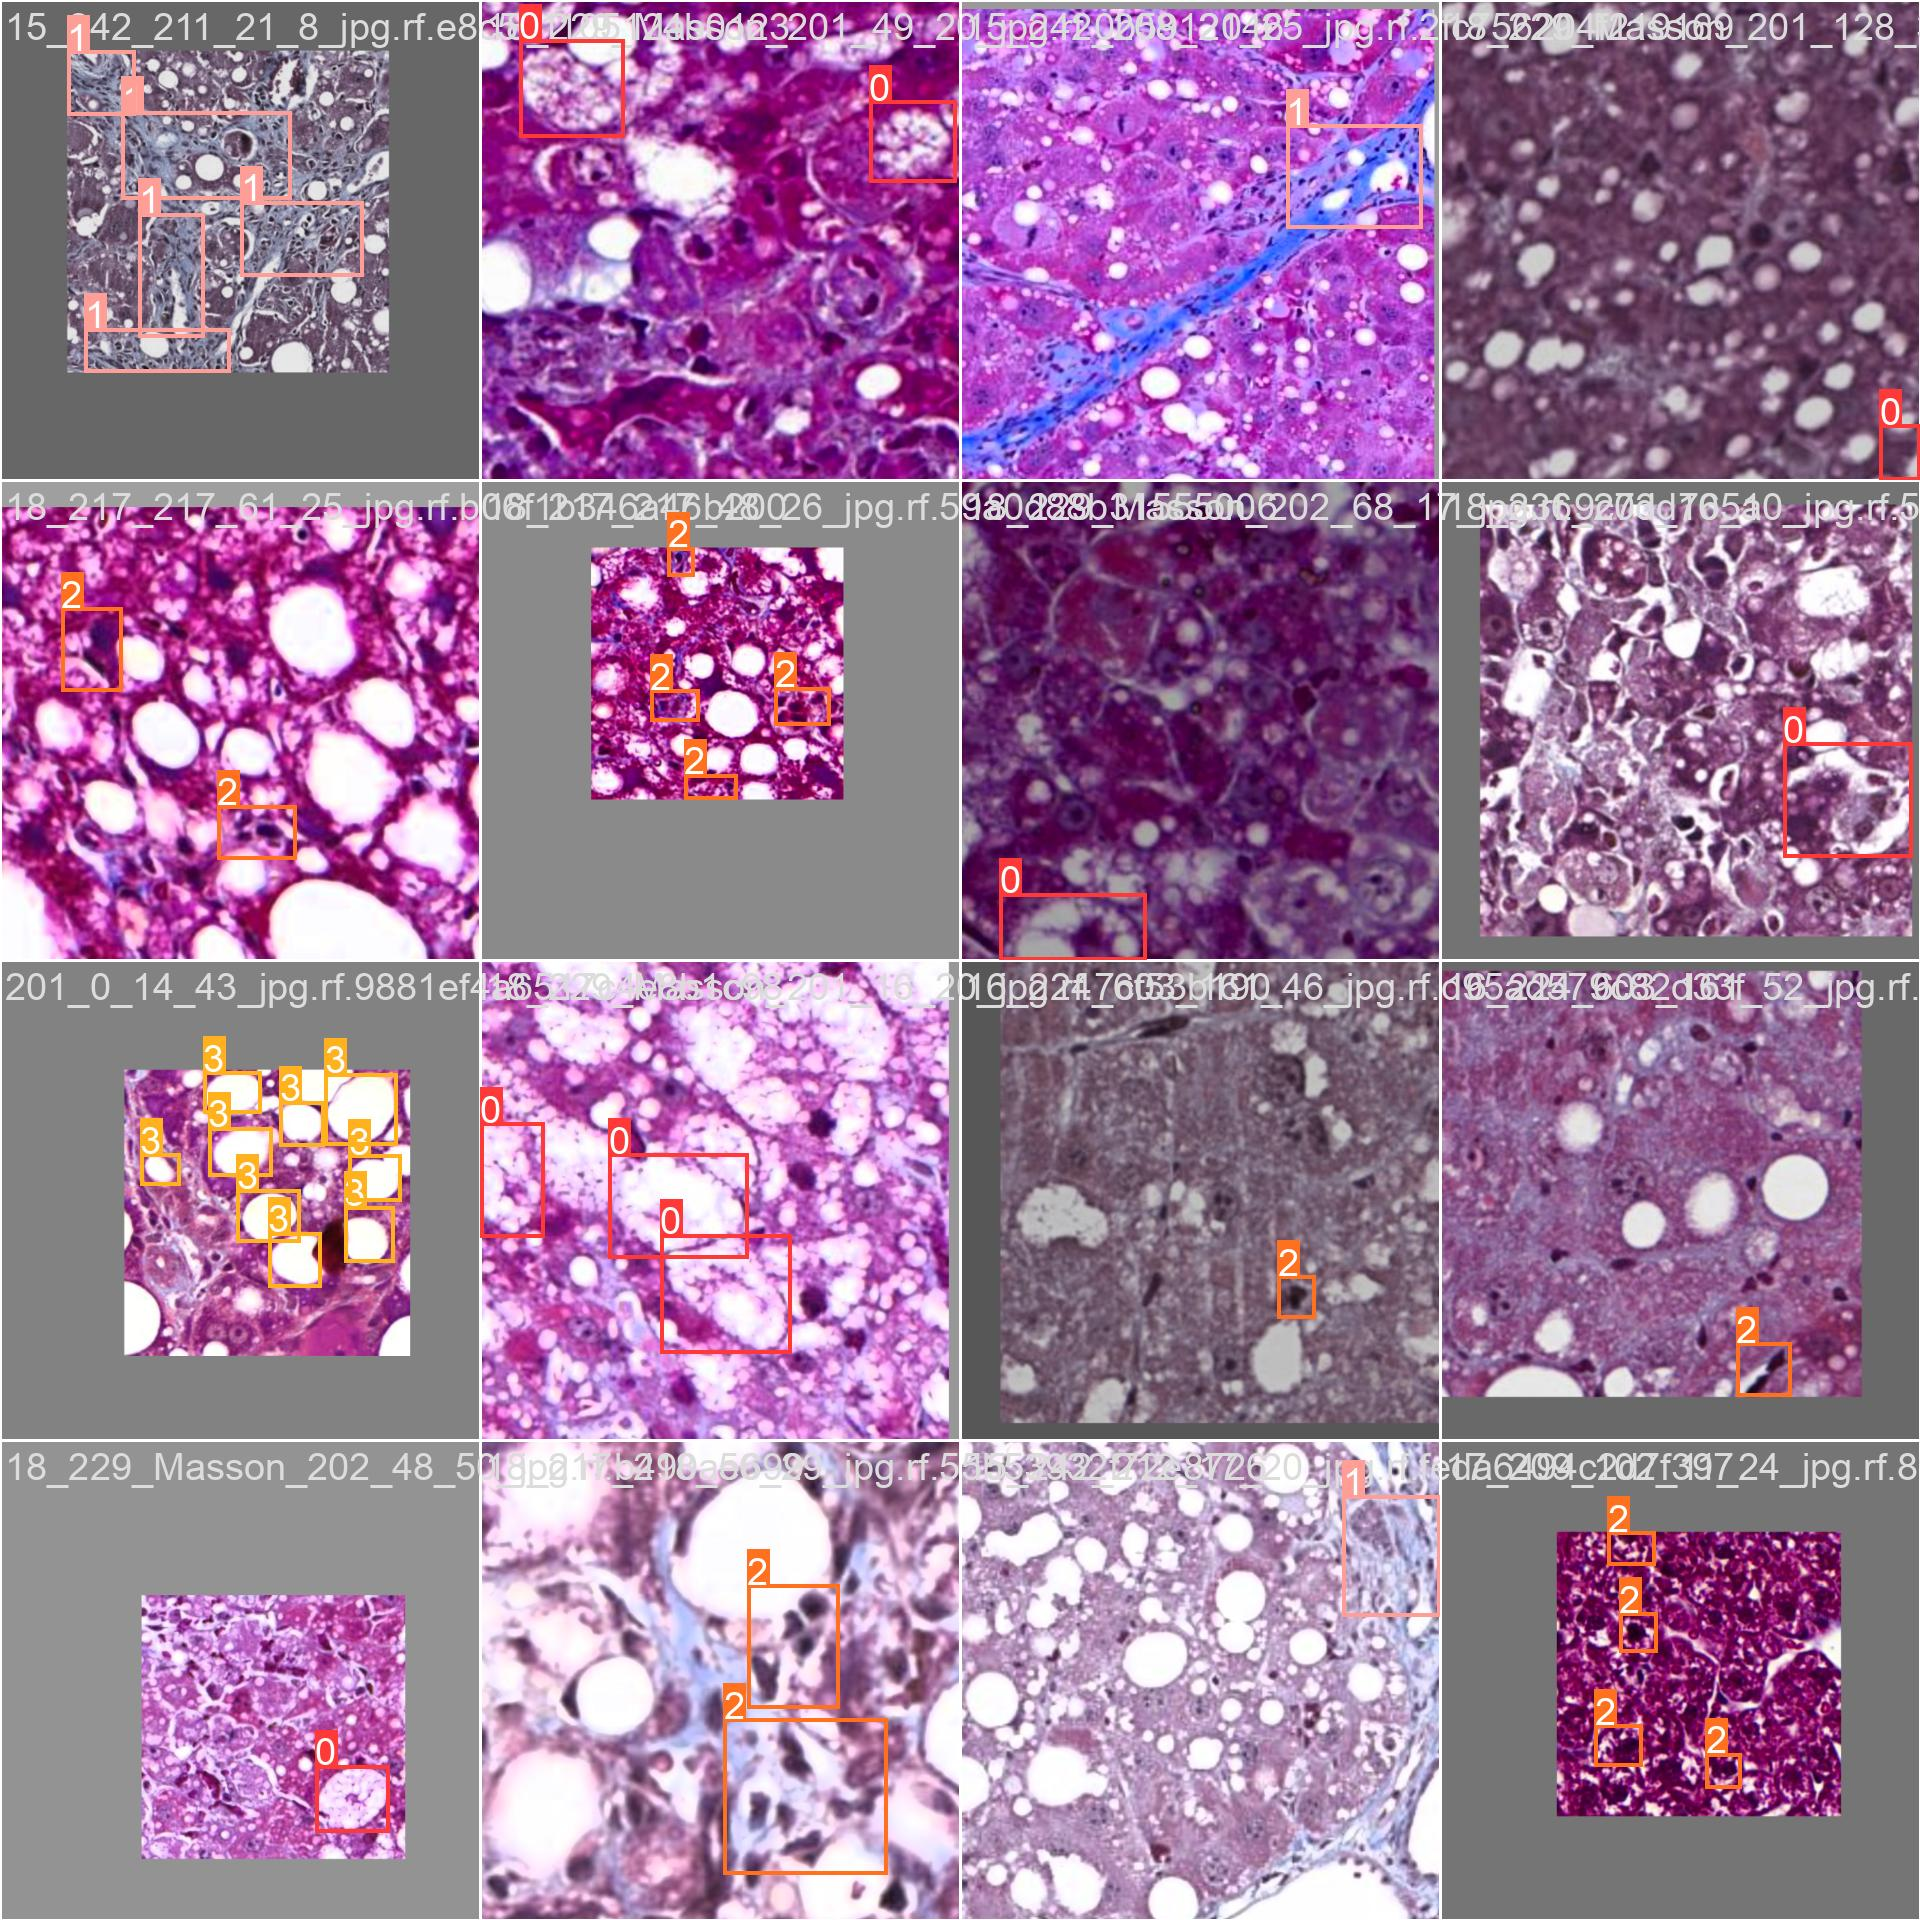

In [ ]:
Image('/content/runs/detect/train4/val_batch1_pred.jpg')

In [ ]:
model2 = YOLO("yolov8n.yaml")
model2 = YOLO('yolov8n.pt') # loading pretrained weights


                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128

In [ ]:
results2 = model2.train(data = '/content/liver-disease-2/data.yaml' , epochs = 50 )

Ultralytics YOLOv8.0.228 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/liver-disease-2/data.yaml, epochs=50, time=None, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train5, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_width

train: Scanning /content/liver-disease-2/train/labels.cache... 2782 images, 8 backgrounds, 0 corrupt: 100%|██████████| 2782/2782 [00:00<?, ?it/s]

train: WARNING ⚠️ /content/liver-disease-2/train/images/208_5_14_31_jpg.rf.82f7adcfc8039be1329a0ad6dce37f71.jpg: 1 duplicate labels removed
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/liver-disease-2/valid/labels.cache... 794 images, 4 backgrounds, 0 corrupt: 100%|██████████| 794/794 [00:00<?, ?it/s]


Plotting labels to runs/detect/train5/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00125, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      4.64G      1.504      2.977      1.512         53        640: 100%|██████████| 174/174 [00:58<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.31it/s]

                   all        794       1937      0.278      0.402       0.28      0.173



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50       4.5G      1.442      2.336      1.439         64        640: 100%|██████████| 174/174 [00:58<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:08<00:00,  2.81it/s]

                   all        794       1937      0.211      0.505      0.277      0.167



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      4.52G      1.452      2.124      1.436         75        640: 100%|██████████| 174/174 [00:53<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:08<00:00,  2.95it/s]

                   all        794       1937      0.371      0.465      0.372      0.236



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      4.52G      1.445      2.027      1.446         53        640: 100%|██████████| 174/174 [00:55<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.53it/s]

                   all        794       1937      0.364      0.398      0.349      0.213



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50       4.5G       1.39      1.878      1.396         47        640: 100%|██████████| 174/174 [00:56<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.34it/s]

                   all        794       1937      0.317      0.558      0.427       0.27



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      4.51G      1.398      1.872       1.42         49        640: 100%|██████████| 174/174 [00:54<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:08<00:00,  2.98it/s]

                   all        794       1937      0.355      0.523      0.439      0.278



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50       4.5G      1.354      1.789      1.377         72        640: 100%|██████████| 174/174 [00:55<00:00,  3.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:08<00:00,  2.94it/s]

                   all        794       1937      0.346      0.556      0.441      0.279



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      4.52G      1.378      1.784      1.392         43        640: 100%|██████████| 174/174 [00:54<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.13it/s]

                   all        794       1937      0.379      0.577      0.453      0.289



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      4.52G       1.35      1.733      1.382         54        640: 100%|██████████| 174/174 [00:55<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:08<00:00,  2.99it/s]

                   all        794       1937      0.434      0.431      0.416      0.269



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      4.51G      1.337      1.696      1.352         77        640: 100%|██████████| 174/174 [00:54<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.38it/s]

                   all        794       1937      0.439      0.551      0.488      0.309



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50       4.5G      1.337      1.672      1.364         50        640: 100%|██████████| 174/174 [00:54<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:08<00:00,  2.92it/s]

                   all        794       1937      0.346      0.577      0.449      0.286



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      4.49G      1.315      1.631      1.349         49        640: 100%|██████████| 174/174 [00:53<00:00,  3.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:08<00:00,  2.93it/s]

                   all        794       1937      0.461      0.544      0.496      0.316



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50       4.5G      1.305       1.63      1.354         77        640: 100%|██████████| 174/174 [00:58<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:08<00:00,  2.88it/s]

                   all        794       1937       0.43      0.526      0.448      0.296



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      4.52G      1.321      1.639      1.356         54        640: 100%|██████████| 174/174 [00:58<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:08<00:00,  3.11it/s]

                   all        794       1937      0.472      0.498      0.475      0.311



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      4.49G      1.293      1.591       1.34         59        640: 100%|██████████| 174/174 [00:57<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:08<00:00,  2.80it/s]

                   all        794       1937      0.438      0.584      0.514      0.335



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      4.52G        1.3      1.586      1.347         41        640: 100%|██████████| 174/174 [01:00<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.24it/s]

                   all        794       1937      0.455       0.59      0.523      0.335



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      4.51G      1.285      1.592      1.349         65        640: 100%|██████████| 174/174 [00:56<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.33it/s]

                   all        794       1937      0.428      0.502      0.491      0.306



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      4.51G       1.29      1.555      1.334         46        640: 100%|██████████| 174/174 [00:59<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:08<00:00,  3.09it/s]

                   all        794       1937      0.524      0.544      0.534       0.34



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      4.49G      1.274      1.545       1.33         50        640: 100%|██████████| 174/174 [00:57<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:08<00:00,  2.88it/s]

                   all        794       1937      0.436      0.559      0.494      0.321



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      4.51G      1.265      1.511      1.314         50        640: 100%|██████████| 174/174 [00:59<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.24it/s]

                   all        794       1937      0.469      0.564      0.522       0.34



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      4.52G      1.263      1.497      1.323         52        640: 100%|██████████| 174/174 [01:00<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.59it/s]

                   all        794       1937      0.482      0.607      0.555      0.353



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      4.52G      1.255      1.499      1.312         52        640: 100%|██████████| 174/174 [00:52<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:08<00:00,  2.91it/s]

                   all        794       1937      0.456      0.603      0.541      0.349



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      4.51G      1.244      1.451      1.306         41        640: 100%|██████████| 174/174 [00:57<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.66it/s]

                   all        794       1937      0.486      0.566      0.533       0.34



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      4.52G      1.248      1.473      1.301         55        640: 100%|██████████| 174/174 [00:55<00:00,  3.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.67it/s]

                   all        794       1937      0.509      0.559      0.545      0.354



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      4.48G      1.251      1.457       1.31         37        640: 100%|██████████| 174/174 [00:56<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:08<00:00,  2.92it/s]

                   all        794       1937      0.498      0.586      0.545      0.352



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      4.52G      1.233      1.455      1.295         64        640: 100%|██████████| 174/174 [00:56<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.56it/s]

                   all        794       1937      0.545      0.573      0.574      0.368



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      4.48G      1.243      1.428      1.303         52        640: 100%|██████████| 174/174 [00:58<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.62it/s]

                   all        794       1937      0.528      0.573      0.561      0.362



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      4.49G      1.232      1.397       1.29         69        640: 100%|██████████| 174/174 [00:56<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.25it/s]

                   all        794       1937      0.522      0.589       0.57      0.364



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      4.51G      1.231      1.398      1.294         49        640: 100%|██████████| 174/174 [00:57<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.43it/s]

                   all        794       1937       0.47      0.584      0.554      0.363



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      4.51G      1.211      1.406       1.29         67        640: 100%|██████████| 174/174 [01:00<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:08<00:00,  2.80it/s]

                   all        794       1937      0.508      0.583      0.562      0.359



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      4.52G      1.225       1.38      1.288         60        640: 100%|██████████| 174/174 [01:05<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:08<00:00,  2.93it/s]

                   all        794       1937      0.479      0.621      0.565      0.364



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      4.47G      1.218      1.382      1.288         37        640: 100%|██████████| 174/174 [01:01<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.15it/s]

                   all        794       1937      0.508      0.613      0.577       0.37



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      4.52G      1.204      1.372      1.277         65        640: 100%|██████████| 174/174 [01:04<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.78it/s]

                   all        794       1937      0.512      0.608      0.581      0.373



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      4.49G      1.197      1.364      1.275         66        640: 100%|██████████| 174/174 [00:58<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.41it/s]

                   all        794       1937      0.529      0.594      0.576      0.369



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50       4.5G      1.221      1.377       1.29         51        640: 100%|██████████| 174/174 [01:01<00:00,  2.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.75it/s]

                   all        794       1937       0.52      0.587      0.588      0.377



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      4.51G      1.199      1.333      1.278         39        640: 100%|██████████| 174/174 [00:56<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:08<00:00,  3.09it/s]

                   all        794       1937      0.538      0.603      0.592      0.378



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      4.51G      1.179      1.306      1.262         48        640: 100%|██████████| 174/174 [00:57<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.55it/s]

                   all        794       1937      0.503      0.605      0.578       0.37



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      4.51G      1.188      1.309      1.268         39        640: 100%|██████████| 174/174 [00:55<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.69it/s]

                   all        794       1937      0.505      0.601      0.571      0.367



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      4.51G      1.182       1.29      1.256         61        640: 100%|██████████| 174/174 [00:54<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:11<00:00,  2.23it/s]

                   all        794       1937      0.537      0.588      0.584      0.376



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      4.52G      1.177        1.3      1.263         48        640: 100%|██████████| 174/174 [00:55<00:00,  3.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.65it/s]

                   all        794       1937      0.517      0.595      0.577      0.369


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      4.65G      1.152      1.268      1.269         29        640: 100%|██████████| 174/174 [00:56<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:06<00:00,  3.58it/s]

                   all        794       1937      0.547      0.602      0.595      0.385



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      4.47G      1.147      1.219      1.263         29        640: 100%|██████████| 174/174 [01:05<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:11<00:00,  2.16it/s]

                   all        794       1937      0.558      0.575      0.586      0.379



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      4.48G      1.138      1.198      1.253         39        640: 100%|██████████| 174/174 [00:51<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:08<00:00,  3.01it/s]

                   all        794       1937      0.567      0.579      0.593      0.382



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      4.47G      1.128      1.175      1.253         29        640: 100%|██████████| 174/174 [00:54<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.56it/s]

                   all        794       1937      0.536      0.597      0.591      0.381



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      4.49G       1.13      1.173      1.254         23        640: 100%|██████████| 174/174 [00:50<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:06<00:00,  3.63it/s]

                   all        794       1937      0.551       0.61      0.602      0.383



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      4.47G      1.123      1.158      1.254         31        640: 100%|██████████| 174/174 [00:52<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.46it/s]

                   all        794       1937      0.527       0.62      0.594      0.382



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      4.48G      1.109      1.144      1.238         28        640: 100%|██████████| 174/174 [00:51<00:00,  3.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.20it/s]

                   all        794       1937       0.58      0.572      0.603      0.385



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      4.47G      1.102       1.11       1.23         40        640: 100%|██████████| 174/174 [00:50<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.77it/s]

                   all        794       1937      0.565      0.589        0.6      0.382



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      4.48G      1.108      1.108      1.243         33        640: 100%|██████████| 174/174 [00:52<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:08<00:00,  3.06it/s]

                   all        794       1937       0.56      0.597        0.6      0.384



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      4.51G        1.1      1.111      1.234         30        640: 100%|██████████| 174/174 [00:49<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:08<00:00,  2.90it/s]

                   all        794       1937       0.57      0.584        0.6      0.385



50 epochs completed in 0.913 hours.
Optimizer stripped from runs/detect/train5/weights/last.pt, 6.3MB
Optimizer stripped from runs/detect/train5/weights/best.pt, 6.3MB

Validating runs/detect/train5/weights/best.pt...
Ultralytics YOLOv8.0.228 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3006428 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:13<00:00,  1.92it/s]


                   all        794       1937      0.581      0.573      0.603      0.385
            ballooning        794        417      0.713      0.772      0.824      0.639
              fibrosis        794        359      0.527      0.368      0.433      0.157
          inflammation        794        558      0.409      0.443      0.394      0.187
             steatosis        794        603      0.675      0.708      0.761      0.557
Speed: 0.3ms preprocess, 2.5ms inference, 0.0ms loss, 2.5ms postprocess per image
Results saved to runs/detect/train5


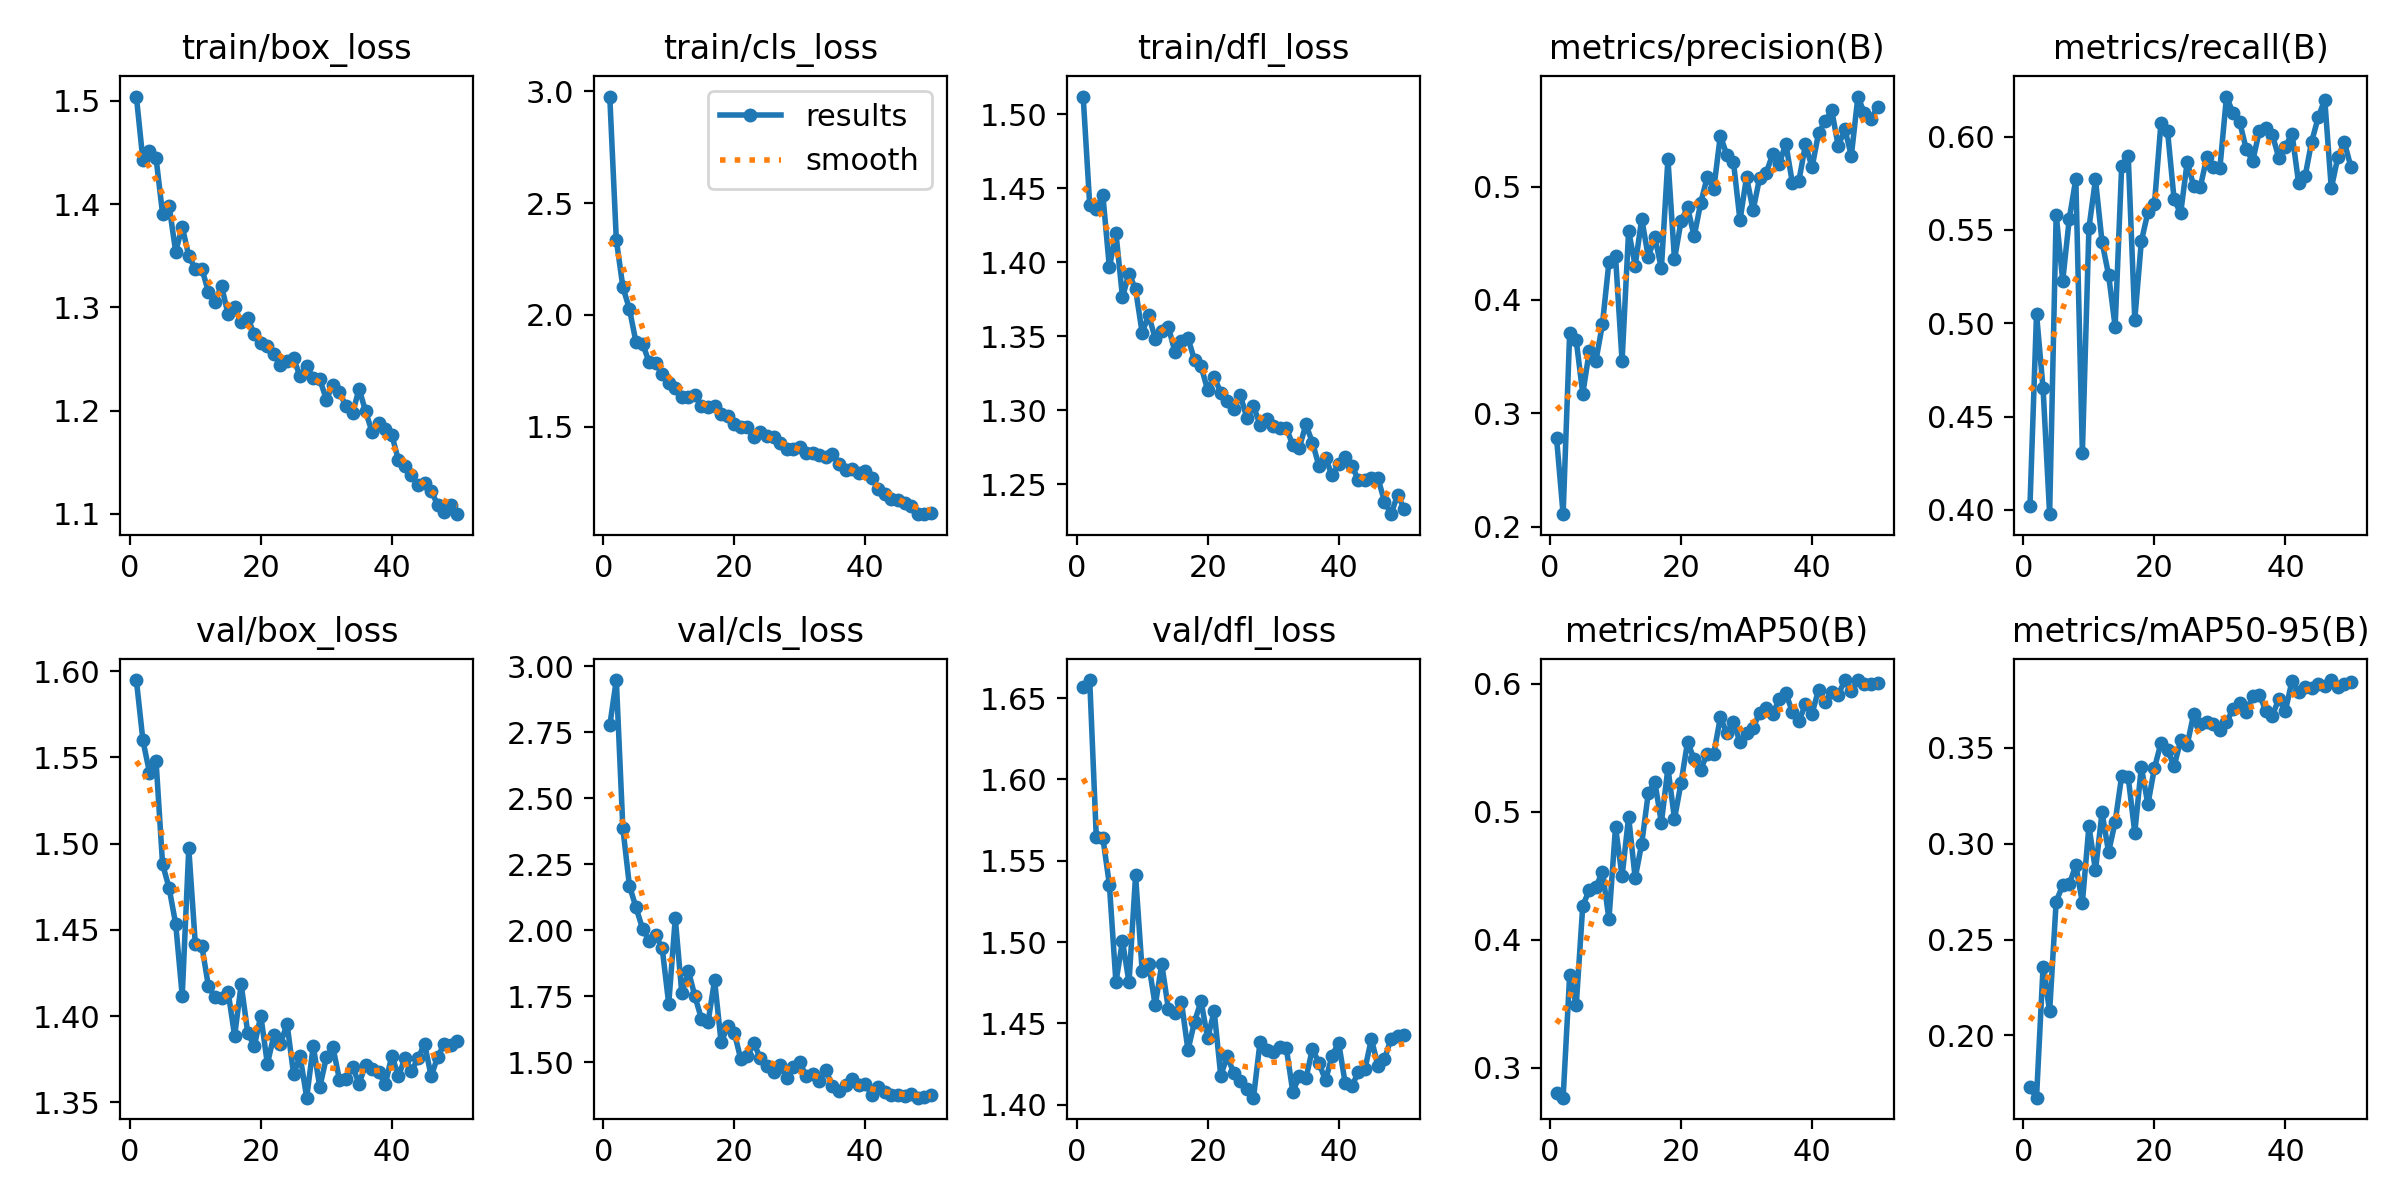

In [ ]:
Image('/content/runs/detect/train2/results.png')

In [ ]:
#define a preprocessing function

def img_preprocessing(image):
  gray_image = cv2.cvtColor(image , cv2.COLOR_BGR2GRAY)
  blurred = cv2.GaussianBlur(gray_image , (5,5) , 0)
  return blurred

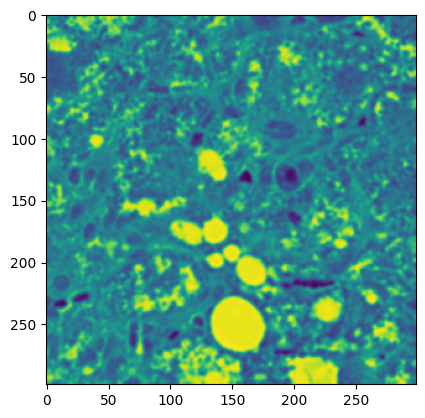

In [ ]:
image = cv2.imread('/content/liver-disease-2/test/images/102_1_3_61_jpg.rf.39ea4cf296518310e4501dfaf587af62.jpg' ,
                   cv2.COLOR_BGR2RGB)
cld = img_preprocessing(image)
plt.imshow(cld)

In [16]:
from ultralytics import YOLO
model3 = YOLO('yolov8m.pt')

In [20]:
results = model3.train( data = '/content/liver-disease-2/data.yaml' , epochs = 50 ,
                       optimizer = 'Adam'  , val = True , lr0 = 0.001)

Ultralytics YOLOv8.0.228 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8m.pt, data=/content/liver-disease-2/data.yaml, epochs=50, time=None, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train7, exist_ok=False, pretrained=True, optimizer=Adam, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_width

train: Scanning /content/liver-disease-2/train/labels.cache... 2782 images, 8 backgrounds, 0 corrupt: 100%|██████████| 2782/2782 [00:00<?, ?it/s]

train: WARNING ⚠️ /content/liver-disease-2/train/images/208_5_14_31_jpg.rf.82f7adcfc8039be1329a0ad6dce37f71.jpg: 1 duplicate labels removed
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/liver-disease-2/valid/labels.cache... 794 images, 4 backgrounds, 0 corrupt: 100%|██████████| 794/794 [00:00<?, ?it/s]


Plotting labels to runs/detect/train7/labels.jpg... 
optimizer: Adam(lr=0.001, momentum=0.937) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005), 83 bias(decay=0.0)
50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      12.7G      1.389       1.83      1.502         53        640: 100%|██████████| 174/174 [01:42<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:12<00:00,  1.97it/s]

                   all        794       1937      0.374      0.454      0.347      0.219



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      11.9G      1.372      1.817      1.478         64        640: 100%|██████████| 174/174 [01:33<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:15<00:00,  1.63it/s]

                   all        794       1937      0.672      0.271      0.314      0.205



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      11.9G      1.398      1.841      1.503         75        640: 100%|██████████| 174/174 [01:32<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:16<00:00,  1.55it/s]

                   all        794       1937      0.316      0.485      0.376       0.24



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      11.9G      1.418      1.893      1.525         53        640: 100%|██████████| 174/174 [01:32<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:14<00:00,  1.72it/s]

                   all        794       1937      0.421      0.361      0.337      0.211



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      11.9G       1.38      1.768      1.485         47        640: 100%|██████████| 174/174 [01:35<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:12<00:00,  1.98it/s]

                   all        794       1937      0.379      0.506      0.417      0.264



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      11.9G      1.389      1.793      1.495         49        640: 100%|██████████| 174/174 [01:32<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:15<00:00,  1.59it/s]

                   all        794       1937      0.332      0.549      0.423      0.263



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      11.9G      1.357      1.729      1.456         72        640: 100%|██████████| 174/174 [01:33<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:15<00:00,  1.58it/s]

                   all        794       1937      0.344      0.433      0.371      0.224



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      11.9G      1.376      1.731      1.481         43        640: 100%|██████████| 174/174 [01:31<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:14<00:00,  1.68it/s]

                   all        794       1937      0.396      0.531      0.447      0.279



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      11.9G      1.341        1.7      1.466         54        640: 100%|██████████| 174/174 [01:31<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:15<00:00,  1.63it/s]

                   all        794       1937      0.414       0.52      0.464      0.289



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      11.9G      1.335      1.678      1.442         77        640: 100%|██████████| 174/174 [01:32<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:14<00:00,  1.76it/s]

                   all        794       1937      0.388      0.537      0.453      0.285



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      11.9G      1.337      1.671      1.447         50        640: 100%|██████████| 174/174 [01:31<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:12<00:00,  1.96it/s]

                   all        794       1937      0.396      0.534      0.466      0.301



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      11.9G      1.308      1.629      1.431         49        640: 100%|██████████| 174/174 [01:31<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:13<00:00,  1.79it/s]

                   all        794       1937      0.375      0.549      0.439      0.275



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      11.9G      1.303      1.619      1.436         77        640: 100%|██████████| 174/174 [01:32<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:12<00:00,  1.97it/s]

                   all        794       1937      0.537      0.486      0.481      0.313



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      11.9G      1.315      1.619       1.43         54        640: 100%|██████████| 174/174 [01:30<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:14<00:00,  1.70it/s]

                   all        794       1937      0.383      0.569      0.472      0.302



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      11.9G       1.29      1.581      1.416         59        640: 100%|██████████| 174/174 [01:31<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:15<00:00,  1.66it/s]

                   all        794       1937      0.456      0.551        0.5      0.325



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      11.9G      1.291      1.572       1.42         41        640: 100%|██████████| 174/174 [01:33<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:15<00:00,  1.62it/s]

                   all        794       1937       0.44      0.584      0.517      0.334



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      11.9G      1.279      1.602      1.428         65        640: 100%|██████████| 174/174 [01:30<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:14<00:00,  1.78it/s]

                   all        794       1937      0.433      0.548      0.498      0.326



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      11.9G      1.291      1.542       1.41         46        640: 100%|██████████| 174/174 [01:32<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:13<00:00,  1.82it/s]

                   all        794       1937      0.496      0.502      0.504      0.329



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      11.9G      1.269      1.543      1.409         50        640: 100%|██████████| 174/174 [01:34<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:12<00:00,  1.99it/s]

                   all        794       1937      0.441      0.552      0.462      0.296



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      11.9G      1.254      1.521      1.383         50        640: 100%|██████████| 174/174 [01:36<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:12<00:00,  1.93it/s]

                   all        794       1937      0.449      0.539      0.472      0.309



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      11.9G      1.249      1.498      1.391         52        640: 100%|██████████| 174/174 [01:32<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:14<00:00,  1.68it/s]

                   all        794       1937      0.455      0.589      0.532      0.339



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      11.9G      1.257      1.487      1.388         52        640: 100%|██████████| 174/174 [01:33<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:12<00:00,  1.96it/s]

                   all        794       1937      0.478      0.531        0.5      0.319



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      11.9G      1.246      1.458      1.377         41        640: 100%|██████████| 174/174 [01:31<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:14<00:00,  1.72it/s]

                   all        794       1937      0.422       0.56      0.491       0.32



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      11.9G      1.245      1.473      1.373         55        640: 100%|██████████| 174/174 [01:35<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:12<00:00,  2.00it/s]

                   all        794       1937       0.49      0.529      0.516      0.334



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      11.9G       1.24      1.457      1.379         37        640: 100%|██████████| 174/174 [01:33<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:12<00:00,  1.99it/s]

                   all        794       1937      0.493      0.569      0.551      0.354



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      11.9G      1.226      1.447      1.366         64        640: 100%|██████████| 174/174 [01:31<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:14<00:00,  1.68it/s]

                   all        794       1937      0.487      0.597      0.538      0.341



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      11.9G      1.224      1.441      1.374         52        640: 100%|██████████| 174/174 [01:33<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:12<00:00,  2.00it/s]

                   all        794       1937      0.486      0.593      0.536      0.347



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      11.9G      1.217      1.388      1.359         69        640: 100%|██████████| 174/174 [01:34<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:12<00:00,  1.98it/s]

                   all        794       1937      0.479      0.594      0.544      0.352



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      11.9G      1.212      1.409      1.363         49        640: 100%|██████████| 174/174 [01:32<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:14<00:00,  1.78it/s]

                   all        794       1937      0.471      0.568      0.529      0.347



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      11.9G        1.2      1.406      1.357         67        640: 100%|██████████| 174/174 [01:30<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:15<00:00,  1.64it/s]

                   all        794       1937      0.493       0.56       0.53      0.341



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      11.9G      1.214      1.384      1.353         60        640: 100%|██████████| 174/174 [01:32<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:12<00:00,  2.01it/s]

                   all        794       1937       0.49      0.586       0.54      0.344



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      11.9G      1.195      1.372      1.347         37        640: 100%|██████████| 174/174 [01:34<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:13<00:00,  1.88it/s]

                   all        794       1937      0.475      0.578       0.53      0.345



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      11.9G      1.185      1.362      1.333         65        640: 100%|██████████| 174/174 [01:32<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:12<00:00,  1.97it/s]

                   all        794       1937       0.51      0.588      0.552      0.355



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      11.9G      1.184      1.381      1.345         66        640: 100%|██████████| 174/174 [01:32<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:12<00:00,  1.99it/s]

                   all        794       1937      0.485        0.6       0.55      0.353



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      11.9G      1.199      1.381      1.356         51        640: 100%|██████████| 174/174 [01:31<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:14<00:00,  1.78it/s]

                   all        794       1937      0.516      0.573      0.555      0.357



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      11.9G      1.175      1.316      1.336         39        640: 100%|██████████| 174/174 [01:34<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:12<00:00,  2.02it/s]

                   all        794       1937      0.518      0.605      0.574      0.369



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      11.9G      1.155      1.285      1.323         48        640: 100%|██████████| 174/174 [01:32<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:13<00:00,  1.83it/s]

                   all        794       1937      0.513      0.574      0.551      0.356



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      11.9G      1.167      1.307      1.332         39        640: 100%|██████████| 174/174 [01:31<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:15<00:00,  1.66it/s]

                   all        794       1937      0.482      0.581      0.549      0.353



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      11.9G      1.156      1.258       1.31         61        640: 100%|██████████| 174/174 [01:33<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:12<00:00,  1.94it/s]

                   all        794       1937      0.521      0.562      0.553      0.362



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      11.9G      1.153      1.266      1.312         48        640: 100%|██████████| 174/174 [01:33<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:13<00:00,  1.87it/s]

                   all        794       1937      0.532      0.602      0.582      0.375


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      11.9G      1.137       1.24      1.359         29        640: 100%|██████████| 174/174 [01:33<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:15<00:00,  1.65it/s]

                   all        794       1937      0.546      0.585      0.585      0.373



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      11.9G      1.124      1.189      1.338         29        640: 100%|██████████| 174/174 [01:32<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:12<00:00,  1.92it/s]

                   all        794       1937      0.547      0.598      0.588      0.373



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      11.9G      1.114      1.149      1.327         39        640: 100%|██████████| 174/174 [01:33<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:12<00:00,  1.96it/s]

                   all        794       1937      0.519      0.591      0.574      0.369



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      11.9G      1.096      1.126      1.318         29        640: 100%|██████████| 174/174 [01:31<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:12<00:00,  1.99it/s]

                   all        794       1937      0.525      0.588      0.582       0.37



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      11.9G      1.093      1.114      1.321         23        640: 100%|██████████| 174/174 [01:31<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:14<00:00,  1.75it/s]

                   all        794       1937      0.553      0.604      0.594      0.377



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      11.9G      1.093      1.102      1.321         31        640: 100%|██████████| 174/174 [01:32<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:12<00:00,  1.94it/s]

                   all        794       1937      0.548      0.584       0.58      0.375



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      11.9G      1.069      1.083      1.303         28        640: 100%|██████████| 174/174 [01:30<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:14<00:00,  1.72it/s]

                   all        794       1937       0.55      0.585      0.578      0.372



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      11.9G      1.057      1.043      1.293         40        640: 100%|██████████| 174/174 [01:30<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:14<00:00,  1.77it/s]

                   all        794       1937      0.548      0.609      0.584      0.373



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      11.9G      1.054      1.029      1.294         33        640: 100%|██████████| 174/174 [01:33<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:12<00:00,  1.98it/s]

                   all        794       1937       0.54      0.612      0.591      0.377



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      11.9G      1.046      1.024      1.283         30        640: 100%|██████████| 174/174 [01:32<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:12<00:00,  1.98it/s]

                   all        794       1937      0.559       0.59       0.59      0.377



50 epochs completed in 1.655 hours.
Optimizer stripped from runs/detect/train7/weights/last.pt, 52.0MB
Optimizer stripped from runs/detect/train7/weights/best.pt, 52.0MB

Validating runs/detect/train7/weights/best.pt...
Ultralytics YOLOv8.0.228 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 218 layers, 25842076 parameters, 0 gradients, 78.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:25<00:00,  1.03s/it]


                   all        794       1937      0.558      0.591       0.59      0.378
            ballooning        794        417      0.704      0.803      0.815      0.634
              fibrosis        794        359      0.523      0.396      0.437      0.159
          inflammation        794        558      0.398      0.419      0.381      0.172
             steatosis        794        603      0.609      0.745      0.729      0.545
Speed: 0.3ms preprocess, 9.7ms inference, 0.0ms loss, 3.1ms postprocess per image
Results saved to runs/detect/train7


In [29]:
HOME = os.getcwd()

In [2]:
# clone ultralytics
%cd {HOME}
! git clone https://github.com/ultralytics/ultralytics

%cd {HOME}/ultralytics
!pip install qe ultralytics


[Errno 2] No such file or directory: '{HOME}'
/content
Cloning into 'ultralytics'...
remote: Enumerating objects: 21652, done.
remote: Counting objects: 100% (904/904), done.
remote: Compressing objects: 100% (431/431), done.
remote: Total 21652 (delta 630), reused 662 (delta 472), pack-reused 20748
Receiving objects: 100% (21652/21652), 11.47 MiB | 13.73 MiB/s, done.
Resolving deltas: 100% (15267/15267), done.
[Errno 2] No such file or directory: '{HOME}/ultralytics'
/content
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 661.2/661.2 kB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 20.9 MB/s eta 0:00:00
  Created wheel for qe: filename=qe-1.0.4-py2.py3-none-any.whl size=1846 sha256=b33b6616ec58cca1c3ab5bb374d863c0f1a5b4c29e33be0ae9f35e69ecef822d
  Stored in directory: /root/.cache/pip/wheels/78/ea/04/b90b234919b906178d60135f8450dbf5abc4d73bdf38b10850
Successfully built qe


In [21]:
# # Define custom preprocessing function
# def my_custom_preprocessing_function(image):
#     # Apply desired colormap to grayscale image
#     colored_image = cv2.applyColorMap(image, cv2.COLORMAP_HOT)
#     return colored_image

# # Pass custom preprocessing function to create_dataloader
# train_dataloader = create_dataloader(train_path, imgsz=imgsz, batch_size=batch_size,
#                                       quad=False, rect=False,
#                                       cache=False, single_cls=False,
#                                       augment=False, workers=workers,
#                                       pad=0.0, preproc_fn=my_custom_preprocessing_function)